<a href="https://colab.research.google.com/github/Ghonem22/Learning-Pytorch-with-simple-XOR-implemetnation/blob/main/Learning_Pytorch_by_XOR_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## What will we cover in this notebook:

1. nn.Module
2. torch.utils.data
3. dataloader
4. pytorch model
5. training simple classifier
6. evaluation

### XOR:

1. it predict 1 if any of x1 or x2 = 1
2. it presict 0 if both of x1 and x2 = 1 or 0

In [ ]:
## Standard libraries
import os
import math
import numpy as np
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm


C:\Users\aghon\AppData\Local\Temp/ipykernel_19016/2723528654.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [ ]:
import torch

In [ ]:
print(torch.__version__)

1.10.1


In [ ]:
print(torch.cuda.is_available())

True


## Building the model using torch.nn


In [ ]:
import torch.nn as nn
import torch.nn.functional as F


C:\Users\aghon\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\aghon\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\aghon\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


**torch.nn** defines a series of useful classes like linear networks layers, activation functions, loss functions etc.

---

There is also **torch.nn.functional** which contains functions that are used in network layers

### our Simple classifier
small_neural_network.svg

In [ ]:
class SimpleClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        # Initialize the modules we need to build the network
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x


We will build **binary clasification** with **two input neurons** and **four hidden neurons**

In [ ]:
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
# Printing a module shows all its submodules
print(model)


SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)


### show model parameters

In [ ]:
for name, param in model.named_parameters():
    print(f"{name}:   \n    {param}    \n\n\n")

linear1.weight:   
    Parameter containing:
tensor([[ 0.1618, -0.6560],
        [-0.5086,  0.5033],
        [ 0.6266,  0.0468],
        [ 0.4126,  0.3365]], requires_grad=True)    



linear1.bias:   
    Parameter containing:
tensor([0.6433, 0.0833, 0.5134, 0.3498], requires_grad=True)    



linear2.weight:   
    Parameter containing:
tensor([[ 0.4333,  0.2561, -0.2977,  0.3219]], requires_grad=True)    



linear2.bias:   
    Parameter containing:
tensor([0.2514], requires_grad=True)    





**Observe that  tanh activation function does not have any parameters**

### The data using torch.utils.data


In [ ]:
import torch.utils.data as data


The data package defines two classes which are the standard interface for handling data in PyTorch:

**data.Dataset**, and **data.DataLoader**. 

* The dataset class provides an uniform interface to access the training/test data.

* the data loader makes sure to efficiently load and stack the data points from the dataset into batches during training.



#### The dataset class

To define a dataset in PyTorch, we simply specify two functions: __ getitem __, and __ len __. 

* The get-item function has to return the -th data point in the dataset

* the len function returns the size of the dataset


In [ ]:
class XORDataset(data.Dataset):

    def __init__(self, size, std=0.1):
        """
        Inputs:
            size - Number of data points we want to generate
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.std * torch.randn(data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

In [ ]:
dataset = XORDataset(size=200)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])


Size of dataset: 200
Data point 0: (tensor([-0.1350,  0.0135]), tensor(0))


### visualize results

In [ ]:
def visualize_samples(data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()
    


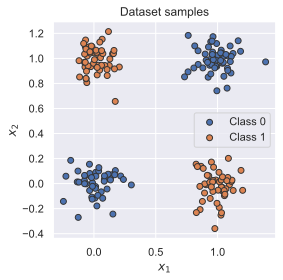

In [ ]:
visualize_samples(dataset.data, dataset.label)

### The data loader class

The class torch.utils.data.DataLoader represents a Python iterable over a dataset with support for automatic batching, multi-process data loading and many more features.

---
The data loader communicates with the dataset using the function __ getitem __ , and stacks its outputs as tensors over the first dimension to form a batch.

---

we usually don’t have to define our own data loader class, but can just create an object of it with the dataset as input.

---
we can configure our data loader with the following input arguments (only a selection, see full list here):


* **batch_size**: Number of samples to stack per batch

* **shuffle**: If True, the data is returned in a random order. This is important during training for introducing stochasticity.

* **num_workers**: Number of subprocesses to use for data loading. The default, 0, means that the data will be loaded in the main process which can slow down training for datasets where loading a data point takes a considerable amount of time (e.g. large images). More workers are recommended for those, but can cause issues on Windows computers. For tiny datasets as ours, 0 workers are usually faster.

* **pin_memory**: If True, the data loader will copy Tensors into CUDA pinned memory before returning them. This can save some time for large data points on GPUs. Usually a good practice to use for a training set, but not necessarily for validation and test to save memory on the GPU.

* **drop_last**: If True, the last batch is dropped in case it is smaller than the specified batch size. This occurs when the dataset size is not a multiple of the batch size. Only potentially helpful during training to keep a consistent batch size.




In [ ]:
data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True)


In [ ]:
data_inputs, data_labels = next(iter(data_loader))
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)


Data inputs torch.Size([8, 2]) 
 tensor([[-0.0196,  0.0481],
        [ 0.9568,  0.9606],
        [ 0.0849,  0.0618],
        [ 0.8840,  0.1213],
        [ 0.0383,  0.1012],
        [ 0.9189,  0.9689],
        [ 0.9781, -0.3592],
        [ 0.0262,  0.9279]])
Data labels torch.Size([8]) 
 tensor([0, 0, 0, 1, 0, 0, 1, 1])


## Optimization

* Get a batch from the data loader

* Obtain the predictions from the model for the batch

* Calculate the loss based on the difference between predictions and labels

* Backpropagation: calculate the gradients for every parameter with respect to the loss

* Update the parameters of the model in the direction of the gradients



### Loss modules

**For instance, for binary classification, we can use Binary Cross Entropy (BCE):**

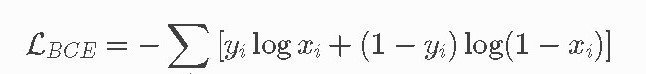


 PyTorch already provides a list of predefined loss functions which we can use 
For instance, for BCE, PyTorch has two modules: 
* nn.BCELoss()
* nn.BCEWithLogitsLoss(). 

nn.BCELoss expects the inputs  to be in the range [0 , 1]

In [ ]:
loss_module = nn.BCEWithLogitsLoss()


### Stochastic Gradient Descent

**For updating the parameters, PyTorch provides the package torch.optim that has most popular optimizers implemented**

---
**We will use her the most simplist optimizers: torch.optim.SGD**

Stochastic Gradient Descent updates parameters by multiplying the gradients with a small constant, called learning rate, and subtracting those from the parameters (hence minimizing the loss). Therefore, we slowly move towards the direction of minimizing the loss. A good default value of the learning rate for a small network as ours is 0.1.

In [ ]:
# Input to the optimizer are the parameters of the model: model.parameters()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)


The optimizer provides two useful functions: 
* optimizer.step()
* optimizer.zero_grad(). 

---
- The step function updates the parameters based on the gradients as explained above.

- The function optimizer.zero_grad() sets the gradients of all parameters to zero.

- While this function seems less relevant at first, it is a crucial pre-step before performing backpropagation. 

- If we would call the backward function on the loss while the parameter gradients are non-zero from the previous batch, the new gradients would actually be added to the previous ones instead of overwriting them. 

- This is done because a parameter might occur multiple times in a computation graph, and we need to sum the gradients in this case instead of replacing them. 

- Hence, remember to call optimizer.zero_grad() before calculating the gradients of a batch.



## Training

**Finally, we are ready to train our model**

In [ ]:
train_dataset = XORDataset(size=2500)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)


Now, we can write a small training function. 

**our five steps:** 

* load a batch
* obtain the predictions
* calculate the loss
* backpropagate
* update. 

---
we have to push all data and model parameters to the device of our choice (GPU if available). 


---

For the tiny neural network we have, communicating the data to the GPU actually takes much more time than we could save from running the operation on GPU

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# Push model to device. Has to be only done once
model.to(device)


SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)

**set our model to training mode**

This is done by calling **model.train()**. 

There exist certain modules that need to perform a different forward step during training than during testing (e.g. BatchNorm and Dropout), and we can switch between them using model.train() and model.eval().



In [ ]:
def train_model(model, optimizer, data_loader, loss_module, num_epochs=100):
    # Set model to train mode
    model.train()

    # Training loop
    for epoch in tqdm(range(num_epochs)):
        for data_inputs, data_labels in data_loader:

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]

            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_labels.float())

            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()

            ## Step 5: Update the parameters
            optimizer.step()


In [ ]:
train_model(model, optimizer, train_data_loader, loss_module)


  0%|          | 0/100 [00:00<?, ?it/s]

## Saving the model


In [ ]:
state_dict = model.state_dict()
print(state_dict)


OrderedDict([('linear1.weight', tensor([[ 0.9680, -3.0725],
        [-2.0279,  1.3377],
        [ 3.0742, -2.3480],
        [ 3.0977,  2.8492]], device='cuda:0')), ('linear1.bias', tensor([ 0.4066, -0.6551,  1.0507, -1.0074], device='cuda:0')), ('linear2.weight', tensor([[ 4.3294,  1.5653, -3.4810,  4.6438]], device='cuda:0')), ('linear2.bias', tensor([0.4257], device='cuda:0'))])


In [ ]:
# torch.save(object, filename). For the filename, any extension can be used
torch.save(state_dict, "our_model.tar")


## Loading the model


In [ ]:
# Load state dict from the disk (make sure it is the same name as above)
state_dict = torch.load("our_model.tar")

# Create a new model and load the state
new_model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
new_model.load_state_dict(state_dict)

# Verify that the parameters are the same
print("Original model\n", model.state_dict())
print("\nLoaded model\n", new_model.state_dict())


Original model
 OrderedDict([('linear1.weight', tensor([[ 0.9680, -3.0725],
        [-2.0279,  1.3377],
        [ 3.0742, -2.3480],
        [ 3.0977,  2.8492]], device='cuda:0')), ('linear1.bias', tensor([ 0.4066, -0.6551,  1.0507, -1.0074], device='cuda:0')), ('linear2.weight', tensor([[ 4.3294,  1.5653, -3.4810,  4.6438]], device='cuda:0')), ('linear2.bias', tensor([0.4257], device='cuda:0'))])

Loaded model
 OrderedDict([('linear1.weight', tensor([[ 0.9680, -3.0725],
        [-2.0279,  1.3377],
        [ 3.0742, -2.3480],
        [ 3.0977,  2.8492]])), ('linear1.bias', tensor([ 0.4066, -0.6551,  1.0507, -1.0074])), ('linear2.weight', tensor([[ 4.3294,  1.5653, -3.4810,  4.6438]])), ('linear2.bias', tensor([0.4257]))])


## Evaluation

In [ ]:
test_dataset = XORDataset(size=500)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)


In [ ]:
def eval_model(model, data_loader):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:

            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long() # Binarize predictions to 0 and 1

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]

    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")


In [ ]:
eval_model(model, test_data_loader)


Accuracy of the model: 100.00%


### Visualizing classification boundaries


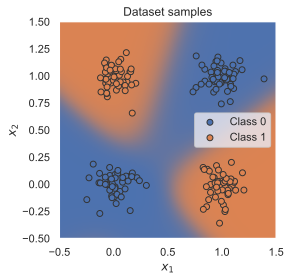

In [ ]:
@torch.no_grad() # Decorator, same effect as "with torch.no_grad(): ..." over the whole function.
def visualize_classification(model, data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    fig = plt.figure(figsize=(4,4), dpi=500)
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

    # Let's make use of a lot of operations we have learned above
    model.to(device)
    c0 = torch.Tensor(to_rgba("C0")).to(device)
    c1 = torch.Tensor(to_rgba("C1")).to(device)
    x1 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    x2 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2)  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds = model(model_inputs)
    preds = torch.sigmoid(preds)
    output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
    output_image = output_image.cpu().numpy()  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig

_ = visualize_classification(model, dataset.data, dataset.label)
plt.show()
